In [1]:
import time
import numpy as np
import types
import os
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
from scipy.special import zeta
import PRyM.PRyM_init as PRyMini
import PRyM.PRyM_thermo as PRyMthermo
import PRyM.test_main3 as test_main
#import PRyM.PRyM_jl_sys as PRyMjl
from numdifftools import Derivative
import PRyM.PRyM_eval_nTOp as PRyMevalnTOp
import PRyM.PRyM_nTOp as PRyMnTOp
import matplotlib.pyplot as plt
import pandas as pd
import random

In [2]:
#generate grid of f_inj v.s. T_end

In [3]:
#observed values, all wrong currently, for testing purposes
YPCMB_obs, Neff_obs, DoHx1e5_obs, Li7oHx1e10_obs = np.array([0.245,3.85,2.547,1.63])
X_obs = np.array([YPCMB_obs, Neff_obs, DoHx1e5_obs, Li7oHx1e10_obs])
YPCMB_sig, Neff_sig, DoHx1e5_sig, Li7oHx1e10_sig = np.array([0.003,0.62,0.0029,0.3])
sigma_X = np.array([YPCMB_sig, Neff_sig, DoHx1e5_sig, Li7oHx1e10_sig])

eta_obs = 6.04*10**(-10)
eta_sigma = 0.118*10**(-10)


In [4]:
#vary 12 key nuclear rates
#params for standard normal 
mu = 0       # Mean
sigma = 1    # Standard deviation
#choose a random sample p using standard normal rate = median_rate*exp(p sigma)
PRyMini.p_npdg = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_dpHe3g = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_ddHe3n = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_ddtp = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_tpag = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_tdan = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_taLi7g = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_He3ntp = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_He3dap = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_He3aBe7g = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_Be7nLi7p = np.random.normal(loc=mu, scale=sigma)
PRyMini.p_Li7paa = np.random.normal(loc=mu, scale=sigma)

#theoretical nuisance parameters
#p is the nuisance parameter which is chosen from standard normal
nus_th = np.array([PRyMini.p_npdg, PRyMini.p_dpHe3g, PRyMini.p_ddHe3n, PRyMini.p_ddtp, PRyMini.p_tpag, PRyMini.p_tdan, PRyMini.p_taLi7g, PRyMini.p_He3ntp, PRyMini.p_He3dap, PRyMini.p_He3aBe7g, PRyMini.p_Be7nLi7p, PRyMini.p_Li7paa])
#observed nuisance parameters
nus_obs = np.zeros(len(nus_th))
#corresponding sigmas for nuisance parameters
sigma_nus = np.array([1 for n in range(len(nus_obs))])



In [5]:
#observed values
#YPCMB_obs, Neff_obs, DoHx1e5_obs, Li7oHx1e10_obs = np.array([0.245,3.85,2.547,1.63])
YPCMB_obs, Neff_obs, DoHx1e5_obs, Li7oHx1e10_obs = np.array([0.245,3.85,2.547,5.853])        #for testing
X_obs = np.array([YPCMB_obs, Neff_obs, DoHx1e5_obs, Li7oHx1e10_obs])
#YPCMB_sig, Neff_sig, DoHx1e5_sig, Li7oHx1e10_sig = np.array([0.003,0.62,0.0029,0.3])
YPCMB_sig, Neff_sig, DoHx1e5_sig, Li7oHx1e10_sig = np.array([0.03,0.62,0.029,0.3])        #for testing
sigma_X = np.array([YPCMB_sig, Neff_sig, DoHx1e5_sig, Li7oHx1e10_sig])

#eta_b experimental values today
#eta_obs = 6.04*10**(-10)
eta_obs = 1.336*10**(-10)
sigma_eta = 0.118*10**(-10)





In [6]:
# Chi^2 function

def chi2_fn(params):
    #initialize stasis parameters
    PRyMini.compute_bckg_flag = True
    PRyMini.save_bckg_flag = True
    PRyMini.stasis_flag = True
    PRyMini.verbose_flag = False
    PRyMini.smallnet_flag = True
    PRyMini.stasis_params['gamma'] = 1
    PRyMini.stasis_params['delta'] = 1
    PRyMini.stasis_params['alpha'] = params[0]
    PRyMini.stasis_params['m0'] = params[1]
    PRyMini.stasis_params['Delta_m'] = params[1]
    #PRyMini.stasis_params['plasma_inject_frac'] = params[2]
    PRyMini.stasis_params['tiny_radiation'] = 0.1
    #PRyMini.stasis_params['stasis_end_mev'] = params[3]
    PRyMini.stasis_params['N_SPECIES'] = 25

    #calculate theoretical values
    run = test_main.PRyMclass()
    results = run.PRyMresults()

    ##extract etab today
    #extract lowest temperature and corresponding radiation density 
    path_stasis = "/Users/alechewitt/Desktop/Stasis/Stasis1/PRyMrates/thermo/stasis_abundances.txt"
    #path_stasis = "/pub/ahewitt1/Stasis_new/Stasis1/PRyMrates/thermo/stasis_abundances.txt"
    with open(path_stasis, "r") as f:
        lines = f.readlines()
        last_line = lines[-1].strip()
        last_line = np.array([float(x) for x in last_line.split()])
    kb = 1      #I think this is right in natural units
    T_MeV = last_line[1]
    rho_g = last_line[3]
    n_g = rho_g/T_MeV
    nB = run.nB(run.a_of_T(T_MeV))
    eta_th = nB/n_g

    Neff, Omeganurel, OneOverOmeganunr, YPCMB, YPBBN, DoHx1e5, He3oHx1e5, Li7oHx1e10 = results
    #X_th = np.array([Neff, Omeganurel, OneOverOmeganunr, YPCMB, YPBBN, DoHx1e5, He3oHx1e5, Li7oHx1e10])
    X_th = np.array([YPCMB, Neff, DoHx1e5, Li7oHx1e10])
    #print('observables: ',X_th)
    #print('etab: ',eta_th)
    return sum(((X_th-X_obs)/sigma_X)**2) + ((eta_th-eta_obs)/sigma_eta)**2 + sum(((nus_th-nus_obs)/sigma_nus)**2)



# Gradient of chi^2 (numerical)
def grad_chi2(chi2_fn,params, eps=1e-3):
    grad = np.zeros_like(params)
    for i in range(len(params)):
        dparams = np.zeros_like(params)
        dparams[i] = eps
        grad[i] = (chi2_fn(params + dparams) - chi2_fn(params - dparams)) / (2 * eps)
    return grad


In [7]:
#adaptive gradient method
def adagrad_minimize(chi2_fn, params_init, lr=0.0001, epsilon=1e-8, max_iters=1000, tol=1e-6, verbose=True):
    params = np.array(params_init, dtype=np.float64)
    G = np.zeros_like(params)
    
    for t in range(1, max_iters + 1):
        grad = grad_chi2(chi2_fn, params)
        G += grad ** 2
        adjusted_grad = grad / (np.sqrt(G) + epsilon)
        update = lr * adjusted_grad
        params -= update
        #params[-1] = int(np.floor(params[-1]))#N_species needs to be an integer
        learning_rate = lr / (np.sqrt(G) + epsilon)
        if verbose:
            print(f"Iter {t}: params = {params}, chisq = {chi2_fn(params):.6f}")
        
        if np.linalg.norm(update) < tol:
            break
            
    return params

In [8]:
PRyMini.stasis_params

{'gamma': 7,
 'delta': 1,
 'm0': 1,
 'Delta_m': 1,
 'N_SPECIES': 10,
 'GAMMA_OVER_H': 100000.0,
 'stasis_end_mev': 50,
 'tiny_radiation': 0.01,
 'plasma_inject_frac': 0.1,
 'alpha': 1.0}

In [9]:
#run stasis gradient descent and save results ot a file
# Optional: write header only once
'''file_name = "results_grad_descent.txt"
with open(file_name, "w") as ff:
    ff.write("gamma delta alpha delm m0 fplas f Tend Nspecies chi2\n")
#initialize random stasis parameters in the desired intervals
gamma = 1
delta = 1
alpha = random.uniform(-1/delta,(gamma/2)-(1/delta))
delm = random.uniform(1,10)
m0 = delm
fplas = random.uniform(0.1,1)
f = 0.1
Tend = random.uniform(0.1, 10)
#Nspecies = int(random.randint(1, 20)) #old
Nspecies = int(25)

#eta0b
PRyMini.eta0b = random.uniform(1e-11,1e-9 )

#initialize params
params = [alpha, delm, fplas, Tend]
params = np.array(params)
print(params)'''

#print(chi2_fn_test(params))

#adagrad_minimize(chi2_fn, params, lr=0.1, epsilon=1e-4, max_iters=100, tol=1e-6, verbose=True)

'file_name = "results_grad_descent.txt"\nwith open(file_name, "w") as ff:\n    ff.write("gamma delta alpha delm m0 fplas f Tend Nspecies chi2\n")\n#initialize random stasis parameters in the desired intervals\ngamma = 1\ndelta = 1\nalpha = random.uniform(-1/delta,(gamma/2)-(1/delta))\ndelm = random.uniform(1,10)\nm0 = delm\nfplas = random.uniform(0.1,1)\nf = 0.1\nTend = random.uniform(0.1, 10)\n#Nspecies = int(random.randint(1, 20)) #old\nNspecies = int(25)\n\n#eta0b\nPRyMini.eta0b = random.uniform(1e-11,1e-9 )\n\n#initialize params\nparams = [alpha, delm, fplas, Tend]\nparams = np.array(params)\nprint(params)'

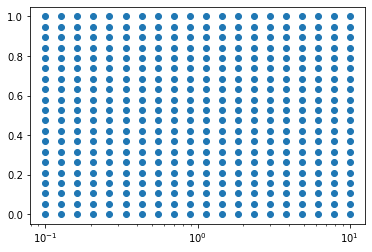

In [10]:
#create a grit of T_ends, and f_inj
def create_flat_grid(x_range, y_range, num_x=100, num_y=100, log_x=False, log_y=False):
    """
    Create flattened x and y arrays covering a 2D grid over the given ranges.

    Parameters:
    - x_range: tuple (xmin, xmax)
    - y_range: tuple (ymin, ymax)
    - num_x: number of grid points in x-direction
    - num_y: number of grid points in y-direction
    - log_x: whether to use log spacing for x (xmin and xmax must be > 0)
    - log_y: whether to use log spacing for y (ymin and ymax must be > 0)

    Returns:
    - x_flat: 1D array of x-coordinates
    - y_flat: 1D array of y-coordinates
    """
    if log_x:
        if x_range[0] <= 0 or x_range[1] <= 0:
            raise ValueError("x_range values must be positive for log spacing.")
        x_vals = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), num_x)
    else:
        x_vals = np.linspace(x_range[0], x_range[1], num_x)

    if log_y:
        if y_range[0] <= 0 or y_range[1] <= 0:
            raise ValueError("y_range values must be positive for log spacing.")
        y_vals = np.logspace(np.log10(y_range[0]), np.log10(y_range[1]), num_y)
    else:
        y_vals = np.linspace(y_range[0], y_range[1], num_y)

    x_grid, y_grid = np.meshgrid(x_vals, y_vals)
    return x_grid.ravel(), y_grid.ravel()


T_ends, f_injs = create_flat_grid([0.1,10], [0,1], num_x=20, num_y=20, log_x = True, log_y = False)
plt.scatter(T_ends,f_injs)
plt.xscale('log')

In [11]:
#todo
#need it to print out the input parameters, and then the new parameters
#need two functions
#   one will turn an x, y and n pts, and turn it into a flattened nxn grid of points (done)
#The algorithm will go through every combination of points
#it will try to take a step towards minimizing the gradient, if an error occurs then it will save the last chisq value
#in a text file, f_inj, T_end, chisq, "other params that are best fit"

#next todo
#update grad algo to try to update and if not save the previous
#then make a loop that applies it to every point on the grid.



In [12]:
#create a file
file_name = "results_grad_descent.txt"
with open(file_name, "w") as f:
    f.write(f"T_end f_inj chisq alpha m0 max_iter\n")

In [13]:
#implement the above

#initialize random stasis parameters in the desired intervals
gamma = 1
delta = 1
alpha = random.uniform(-1/delta,(gamma/2)-(1/delta))
delm = random.uniform(1,10)
m0 = delm
fplas = random.uniform(0.1,1)
f = 0.1
Tend = random.uniform(0.1, 10)
#Nspecies = int(random.randint(1, 20)) #old
Nspecies = int(25)

#eta0b
PRyMini.eta0b = random.uniform(1e-11,1e-9 )

#initialize params
#params = [alpha, delm, fplas, Tend]    old
params = [alpha, delm]
params = np.array(params)
print('Initial parameters (alpha, m0): ', params)

max_iter = 20
for n in range(len(T_ends)):
    T_end_temp = T_ends[n]
    f_injs_temp = f_injs[n]
    PRyMini.stasis_params['plasma_inject_frac'] = f_injs_temp
    PRyMini.stasis_params['stasis_end_mev'] = T_end_temp
    for m in range(max_iter):
        try:
            params = adagrad_minimize(chi2_fn, params, lr=0.1, epsilon=1e-4, max_iters=1, tol=1e-6, verbose=True)
        except ValueError or IndexError: 
            #store the params when it encounters an error, i.e. minimize chisq as much as possible
            with open(file_name, "a") as f:
                f.write(f"{T_end_temp} {f_injs_temp} {chisq} {params[0]} {params[1]} {m}\n")
            break


Initial parameters (alpha, m0):  [-0.81845905  5.43794592]
Iter 1: params = [-0.71845905  5.53794592], chisq = 141420104128.002960
Iter 1: params = [-0.61845905  5.63794592], chisq = 121495307985.469238


KeyboardInterrupt: 